# Building a Report Writing Agentic System using Reflection
In this tutorial, we will build a report writing agent that utilizes reflection to iteratively improve its output. By leveraging reflection, the agent can critique its own work and refine it in subsequent iterations, leading to a higher-quality final report.

This approach is inspired by the concept of reflection in LLM agent building, where the agent observes its past outputs and assesses the quality of its actions to enhance future performance.

### Overview
Our report writing agent will:

1. Generate an initial report based on a user-provided topic.
2. Reflect on the generated report by critiquing its content, structure, and style.
3. Iterate the process by incorporating the reflections to improve the report.
4. Repeat the reflection and revision steps for a set number of iterations or until the report meets a desired quality threshold.

### Imports and Setup
We start by importing the necessary libraries and setting up the environment:



In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated, List
from typing_extensions import TypedDict

from dotenv import load_dotenv
import os

_ = load_dotenv()

### Defining the Models
One interesting thing we can do in multi agent systems is to use different models for different agents. 

We use the `gpt-4o-mini` model from OpenAI for the report generation and the `gpt-4o` model from OpenAI for the reflection steps. 

The `gpt-4o-mini` model is cheaper and faster than the `gpt-4o` model, so it is a good choice for the report generation step, while the `gpt-4o` model is more accurate and capable for the reflection step.

In [5]:
# Report Generation Model
generation_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7, max_tokens=1500)

# Reflection Model
reflection_llm = ChatOpenAI(model="gpt-4o", temperature=0, max_tokens=1000)

### Defining the Report Generation Step
We create a chain for generating the initial report:

In [6]:
# Prompt for Report Generation
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional report writer specializing in comprehensive and informative reports."
            " Generate a detailed report based on the user's topic."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Bind the prompt to the LLM
generate_report = generation_prompt | generation_llm


### Defining the Reflection Step
We create a prompt template for reflecting on and critiquing the generated report:

In [7]:
# Prompt for Reflection
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert reviewer tasked with critiquing and providing detailed feedback on reports."
            " Analyze the report for content accuracy, structure, depth, and style."
            " Provide constructive feedback and suggestions for improvement."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Bind the prompt to the LLM
reflect_on_report = reflection_prompt | reflection_llm


### Defining the State
We define the state that will be passed through the LangGraph nodes:

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


### Building the Graph
We create nodes for generation, reflection, and a loop to iterate over the process:


In [9]:
# Initialize the graph builder
builder = StateGraph(State)

# Generation Node
async def generation_node(state: State) -> State:
    return {"messages": [await generate_report.ainvoke(state["messages"])]}

builder.add_node("generate", generation_node)

# Reflection Node
async def reflection_node(state: State) -> State:
    # Swap message roles for reflection
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    res = await reflect_on_report.ainvoke(translated)
    # Treat reflection as human feedback
    return {"messages": [HumanMessage(content=res.content)]}

builder.add_node("reflect", reflection_node)

# Define edges
builder.add_edge(START, "generate")

# Conditional Edge to Determine Continuation
def should_continue(state: State):
    # Limit iterations to prevent infinite loops
    if len(state["messages"]) > 6:  # Adjust based on desired iterations
        return END
    return "reflect"

builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

# Compile the graph with memory checkpointing
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


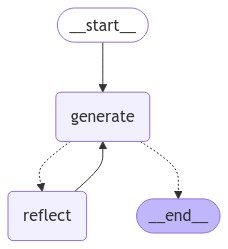

In [13]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Agent
We run the agent with a user-provided topic:


In [11]:
config = {"configurable": {"thread_id": "1"}}
topic = "The Impact of Artificial Intelligence on Modern Healthcare"


In [12]:
async def run_agent():
    async for event in graph.astream(
        {
            "messages": [
                HumanMessage(content=topic)
            ],
        },
        config,
    ):
        if "generate" in event:
            print("=== Generated Report ===")
            print(event["generate"]["messages"][-1].content)
            print("\n")
        elif "reflect" in event:
            print("=== Reflection ===")
            print(event["reflect"]["messages"][-1].content)
            print("\n")

import asyncio
await run_agent()


=== Generated Report ===
# The Impact of Artificial Intelligence on Modern Healthcare

## Executive Summary

Artificial Intelligence (AI) has emerged as a transformative force in modern healthcare, reshaping clinical practices, enhancing patient outcomes, and optimizing operational efficiencies. This report delves into the multifaceted impact of AI in healthcare, examining its applications, benefits, challenges, and future prospects. As technology continues to evolve, understanding AI's role will be crucial for stakeholders across the healthcare spectrum.

## 1. Introduction

The integration of Artificial Intelligence in healthcare represents a paradigm shift in how medical services are delivered. AI encompasses a range of technologies, including machine learning, natural language processing, and robotics, that enable systems to learn from data, identify patterns, and make informed decisions. This report outlines the key areas where AI is making a significant impact, including diagnost

### Conclusion
Congratulations! You've built a report writing agent that leverages reflection to iteratively improve its output. This agent can be a valuable tool for generating high-quality reports on various topics, with the ability to self-critique and refine its work.

Feel free to experiment further by:

- Changing the stock ticker symbol to analyze a different company.
- Modifying the system prompts for each agent to adjust behavior and task focus.
- Adding external APIs like Yahoo Finance or Reuters for broader financial data.
- Adjusting the supervisor to add reflection steps and introduce multiple iterations for quality improvement.